# Appendix B Portfolio solution

This notebook illustrates the numerical computation for portofio choice solution discussed in appendix B.

For the results in Section 5, we solved the HJB equation numerically. While we posed the HJB
equation in Section 5 using $\Sigma_t$ as a state variable, our computations start from a single initialization.
Given the initial $\Sigma_0$, $\Sigma_t$ is strictly decreasing in t. Thus, for computational purposes, we
express the value function in terms $t$ instead of $\Sigma_t$; and solve the corresponding PDE. We derive
this transformed PDE in the remainder of this appendix.



We guess the value function as 

$$
K(x, z, t) = x + K_0(t) + \frac{1}{2} K_2(t) (z - r)^2
$$

Coefficient of $(z-r)^2$ gives rise to the following differential equation:

$$
0 = \frac{d K_2(t)}{ dt} + \frac{1}{\gamma |B_y|^2 + \alpha \Sigma_t} - \delta K_2(t) - 2 \frac{\frac{\Sigma_t}{|B_y|^2} ((\gamma-1)|B_y|^2 + \alpha \Sigma_t)}{\gamma |B_y|^2 + \alpha \Sigma_t} K_2(t) -  \frac{\frac{\Sigma_t^2}{|B_y|^2} ((\gamma-1)|B_y|^2 + \alpha \Sigma_t)}{\gamma |B_y|^2 + \alpha \Sigma_t} K_2(t)^2
$$

The remianing terms give rise to the following differential equation:

$$
0 = \frac{d K_0(t)}{ dt}  - \delta K_0(t) + \delta \log \delta - \delta + r + \frac{1}{2} K_2(t) \frac{\Sigma_t^2}{|B_y|^2}
$$

We will use two terminal conditions to address the above ODEs.

- **Terminal condition 1**:
    T = 100, 000, and $K_2(T)$, $K_0(T)$ satisfy:
    
    $$
        0 = \frac{1}{\gamma |B_y|^2} - \delta K_2(T)
    $$
    and
    $$
        0 = \delta \log \delta - \delta + r - \delta K_0(T)
    $$
    
- **Terminal condition 2**:
    T = 25 and and $K_2(T)$, $K_0(T)$ satisfy:
    
    $$
        K_2(T) = K_0 (T) = 0
    $$
    


To solve the ODEs numerically, we discretize the ODE in the following way:

\begin{align}
\frac{\color{red}{K_2(t)} - \color{red}{K_2(t -1)}}{ dt} &= -\frac{1}{\gamma |B_y|^2 + \alpha \Sigma_t} + \delta \color{red}{K_2(t)} + 2 \frac{\frac{\Sigma_t}{|B_y|^2} ((\gamma-1)|B_y|^2 + \alpha \Sigma_t)}{\gamma |B_y|^2 + \alpha \Sigma_t} \color{red}{K_2(t)} +  \frac{\frac{\Sigma_t^2}{|B_y|^2} ((\gamma-1)|B_y|^2 + \alpha \Sigma_t)}{\gamma |B_y|^2 + \alpha \Sigma_t} \color{red}{K_2(t)}^2\\
\frac{\color{red}{K_0(t)} - \color{red}{K_0(t-1)}}{ dt}  &= \delta \color{red}{K_0(t)} - \delta \log \delta + \delta - r - \frac{1}{2} K_2 \frac{\Sigma_t^2}{|B_y|^2}
\end{align}

with
$$
\Sigma_t = \frac{|B_y|^2 \Sigma_0}{t \Sigma_0 + |B_y|^2}
$$

and we solve $K_2(t)$ and $K_0(t)$ iteratively from $T$ to $t = 0$

## Parameters

Without further explanation, the values of the parameters in the computation are as follows:

| Parameters | Values|
|------| ----|
| $\delta$ | $0.01$|
| $\gamma$ | $5$ |
| $\alpha$ | $0$ |
| $B_y$ | $0.18$ |
| $r$ | $0.02$ |
| $\Sigma_0$ | $0.1^2$|
| $T$ | 25 |

We would also expriment with $\alpha = 3,6$, $\Sigma_0 = 0.05^2, 0.25^2$, and we use **terminal condition 2** if not noted oherwise.

In [1]:
import numpy as np
from numba import njit
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
mpl.rcParams["lines.linewidth"] = 2.5
mpl.rcParams["legend.frameon"] = True
mpl.rcParams["legend.framealpha"] = 0.5

In [3]:
Σ0 = 0.1**2
B_y = 0.18
γ = 5
α = 0
δ = 0.01
r = 0.02
T = 25
dt = 0.1

In [4]:
time = np.arange(0, T+dt, dt)
Σt = B_y**2 * Σ0 / (time * Σ0 + B_y**2)

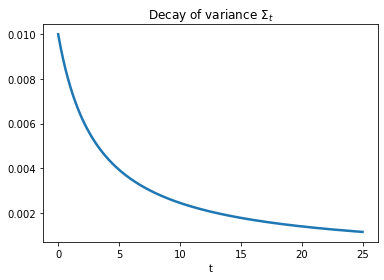

In [5]:
plt.plot(time, Σt)
plt.title("Decay of variance $\Sigma_t$")
plt.xlabel("t")
plt.show()

In [6]:
@njit
def limiting_K2(args):
    Σ0, B_y, γ, α, δ, r = args
    return 1 / (δ * γ * B_y**2)

@njit
def limiting_K0(args):
    Σ0, B_y, γ, α, δ, r = args
    return np.log(δ) - 1 + r / δ 

In [7]:
@njit
def simulate_Σ(T, dt, args):
    time = np.arange(0, T+dt, dt)
    Σ0, B_y, γ, α, δ, r = args
    Σt = B_y**2 * Σ0 / (time * Σ0 + B_y**2)
    return Σt

@njit
def simulate_K2(Σt, T, dt, args, limitingTerm=False):
    Σ0, B_y, γ, α, δ, r = args
    adjust = (γ - 1) * B_y**2 + α * Σt
    denominator =  γ * B_y**2 + α * Σt
    # K2
    K2 = np.zeros_like(Σt)
    T_max = len(K2) - 1
    if limitingTerm:
        K2[-1] = limiting_K2(args)
    for i in range(1, K2.shape[0]):
        K2[T_max - i] = K2[T_max-i+1]
        K2[T_max - i] += 1 / denominator[T_max-i+1] * dt
        K2[T_max - i] -= δ * K2[T_max-i+1] * dt
        K2[T_max - i] -= 2 * Σt[T_max-i+1] / B_y**2 * adjust[T_max-i+1] / denominator[T_max-i+1] * K2[T_max-i+1] * dt
        K2[T_max - i] -= Σt[T_max-i+1] **2 / B_y**2 * adjust[T_max-i+1] / denominator[T_max-i+1] * K2[T_max-i+1]**2 * dt
    
    return K2


@njit
def simulate_K0(T, dt, args, limitingTerm=False):
    Σ0, B_y, γ, α, δ, r = args
    Σt = simulate_Σ(T, dt, args)
    K2 = simulate_K2(Σt, T, dt, args, limitingTerm)
    adjust = (γ - 1) * B_y**2 + α * Σt
    denominator =  γ * B_y**2 + α * Σt
    T_max = Σt.shape[0] - 1
    # K1
    K0 = np.zeros_like(Σt)
    if limitingTerm:
        K0[-1] = limiting_K0(args)
    for i in range(1, K0.shape[0]):
        K0[T_max - i] = K0[T_max - i + 1] - δ * K0[T_max - i + 1] * dt
        K0[T_max - i] += (δ * np.log(δ) - δ + r) * dt
        K0[T_max - i] += 1/2 * K2[T_max-i+1] * Σt[T_max - i + 1]**2 / B_y**2 * dt
        
    return K2, K0

In [8]:
Σt = simulate_Σ(T, dt, args=(Σ0, B_y, γ, α, δ, r))
K2, K0 = simulate_K0(T, dt, args=(Σ0, B_y, γ, α, δ, r))
K24, K04 = simulate_K0(T, dt, args=(Σ0, B_y, γ, 3., δ, r))
K28, K08 = simulate_K0(T, dt, args=(Σ0, B_y, γ, 6., δ, r))
K2h, K0h = simulate_K0(T, dt, args=(0.25**2, B_y, γ, α, δ, r))
K24h, K04h = simulate_K0(T, dt, args=(0.25**2, B_y, γ, 3., δ, r))
K28h, K08h = simulate_K0(T, dt, args=(0.25**2, B_y, γ, 6., δ, r))
K2l, K0l = simulate_K0(T, dt, args=(0.05**2, B_y, γ, α, δ, r))
K24l, K04l = simulate_K0(T, dt, args=(0.05**2, B_y, γ, 3., δ, r))
K28l, K08l = simulate_K0(T, dt, args=(0.05**2, B_y, γ, 6., δ, r))

The solutions are illustration in the following plot: 

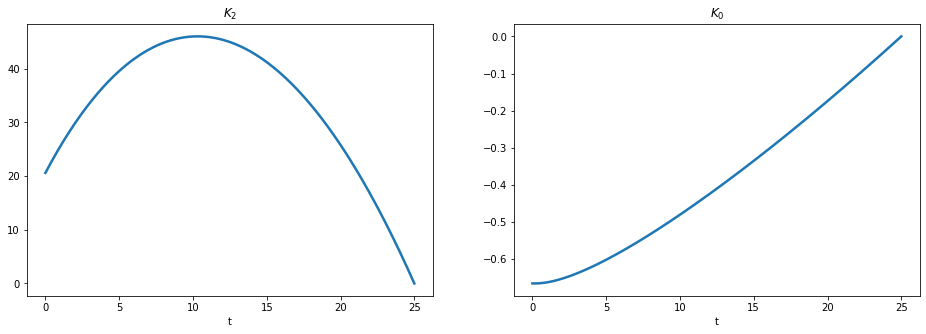

In [9]:
fig, (ax1, ax3) = plt.subplots(1,2, figsize=(16,5))
ax1.plot(time, K2, label="$K_2$")
ax1.set_xlabel("t")
ax1.set_title("$K_2$")

ax3.plot(time, K0, label="$K_0$")
ax3.set_xlabel("t")
ax3.set_title("$K_0$")
plt.show()

## Portfolio choice and expected excess return

We decompose the portofolio into myopic demand and hedging demand:
$$
 \psi^* = \underbrace{\frac{z-r}{\gamma |B_y|^2 + \alpha \Sigma_t}}_{myopic}\quad \underbrace{-  K_2 (z -r) \frac{\Sigma_t}{|B_y|^2} \left(\frac{(\gamma-1) |B_y|^2 + \alpha \Sigma_t}{\gamma |B_y|^2 + \alpha \Sigma_t}  \right)}_{hedging}
$$

We illustrate hedging demand, myopic demand and total demand in terms of expected excess return, $z - r$, at time $t =  0$.


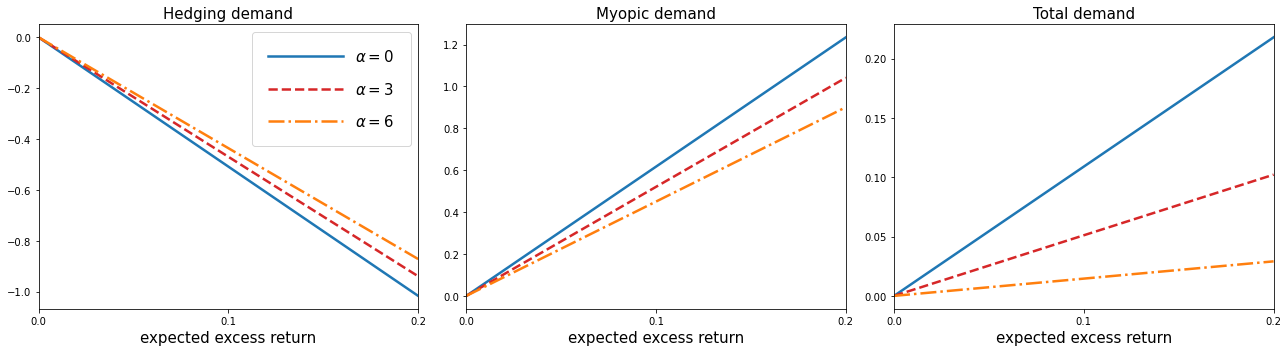

In [10]:
γ = 5
T = 25
αs = [0,  3 , 6]
Σt = simulate_Σ(T, 0.1, args=(Σ0, B_y, γ, αs[0], δ, r))
excess_return = np.linspace(0, 0.2)


def myopic(excess_r, args):
    Σ0, B_y, γ, α, δ, r = args
    return excess_r / (γ * B_y**2 + α * Σ0)

def hegding(excess_r, k2, args):
    Σ0, B_y, γ, α, δ, r = args
    adjust = (γ - 1) * B_y**2 + α * Σ0
    temp = - k2 * excess_r * Σ0 / B_y**2 * adjust 
    temp /= γ * B_y**2 + α * Σ0
    return temp

myopic0 = myopic(excess_return, args=(Σt[0], B_y, γ, αs[0], δ, r))
myopic1 = myopic(excess_return, args=(Σt[0], B_y, γ, αs[1], δ, r))
myopic2 = myopic(excess_return, args=(Σt[0], B_y, γ, αs[2], δ, r))

hedging0 = hegding(excess_return, K2[0], args=(Σt[0], B_y, γ, αs[0], δ, r))
hedging1 = hegding(excess_return, K24[0], args=(Σt[0], B_y, γ, αs[1], δ, r))
hedging2 = hegding(excess_return, K28[0], args=(Σt[0], B_y, γ, αs[2], δ, r))

fig,(ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,5))

ax1.plot(excess_return,  hedging0, label="$\\alpha = 0$")
ax1.plot(excess_return,  hedging1, label="$\\alpha = 3$", color="C3", linestyle="--")
ax1.plot(excess_return,  hedging2, label="$\\alpha = 6$", color="C1", linestyle="-.")
ax1.set_title("Hedging demand", fontsize=15)

ax2.plot(excess_return, myopic0, label="$\\alpha = 0$")
ax2.plot(excess_return, myopic1, label="$\\alpha = 3$", color="C3", linestyle="--")
ax2.plot(excess_return, myopic2, label="$\\alpha = 6$", color="C1", linestyle="-.")
ax2.set_title("Myopic demand", fontsize=15)

ax3.plot(excess_return, myopic0 +  hedging0, label="$\\alpha = 0$")
ax3.plot(excess_return, myopic1 +  hedging1, label="$\\alpha = 3$", color="C3", linestyle="--")
ax3.plot(excess_return, myopic2 +  hedging2, label="$\\alpha = 6$", color="C1", linestyle="-.")
ax3.set_title("Total demand", fontsize=15)

for ax in [ax1, ax2, ax3]:
    ax.set_xticks([0.0, 0.1, 0.2])
    ax.set_xlim(0.0, 0.2)
    ax.set_xlabel("expected excess return", fontsize=15)
ax1.legend(fontsize=15, framealpha=0.8,  handlelength=5, borderpad=1.1, labelspacing=1.1)
    
    
plt.tight_layout()
plt.show()

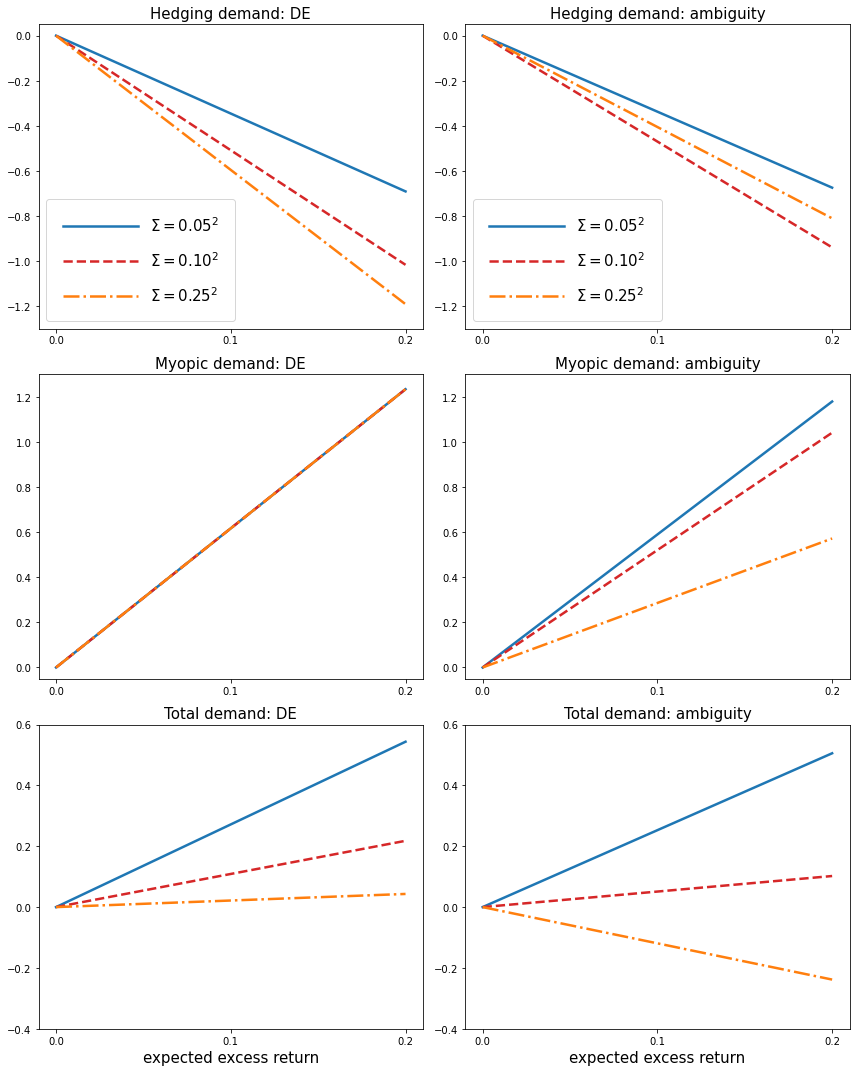

In [11]:
fig, axes = plt.subplots(3,2, figsize=(12, 15))

# γ = 5
# DE
## hedging
α = αs[0]
axes[0,0].plot(excess_return, hegding(excess_return, K2l[0], args=(0.05**2, B_y, γ, α, δ, r)), color="C0")
axes[0,0].plot(excess_return, hegding(excess_return, K2[0], args=(Σt[0], B_y, γ, α, δ, r)), color="C3", linestyle="--")
axes[0,0].plot(excess_return, hegding(excess_return, K2h[0], args=(0.25**2, B_y, γ, α, δ, r)), color="C1", linestyle="-.")
axes[0,0].set_title("Hedging demand: DE", fontsize=15)
## myopic
axes[1,0].plot(excess_return, myopic(excess_return, args=(0.05**2, B_y, γ, α, δ, r)))
axes[1,0].plot(excess_return, myopic(excess_return, args=(Σt[0], B_y, γ, α, δ, r)), color="C3", linestyle="--")
axes[1,0].plot(excess_return, myopic(excess_return, args=(0.25**2, B_y, γ, α, δ, r)), color="C1", linestyle="-.")
axes[1,0].set_title("Myopic demand: DE", fontsize=15)
## total
axes[2,0].plot(excess_return, myopic(excess_return, args=(0.05**2, B_y, γ, α, δ, r)) 
               + hegding(excess_return, K2l[0], args=(0.05**2, B_y, γ, α, δ, r)))
axes[2,0].plot(excess_return, myopic(excess_return, args=(Σt[0], B_y, γ, α, δ, r)) 
               + hegding(excess_return, K2[0], args=(Σt[0], B_y, γ, α, δ, r)), color="C3", linestyle="--")
axes[2,0].plot(excess_return, myopic(excess_return, args=(0.25**2, B_y, γ, α, δ, r)) 
               + hegding(excess_return, K2h[0], args=(0.25**2, B_y, γ, α, δ, r)), color="C1", linestyle="-.")
axes[2,0].set_title("Total demand: DE", fontsize=15)

# ambiguity
α = αs[1]
## hedging
axes[0,1].plot(excess_return, hegding(excess_return, K24l[0], args=(0.05**2, B_y, γ, α, δ, r)))
axes[0,1].plot(excess_return, hegding(excess_return, K24[0], args=(Σt[0], B_y, γ, α, δ, r)), color="C3", linestyle="--")
axes[0,1].plot(excess_return, hegding(excess_return, K24h[0], args=(0.25**2, B_y, γ, α, δ, r)), color="C1", linestyle="-.")
axes[0,1].set_title("Hedging demand: ambiguity", fontsize=15)
## myopic
axes[1,1].plot(excess_return, myopic(excess_return, args=(0.05**2, B_y, γ, α, δ, r)))
axes[1,1].plot(excess_return, myopic(excess_return, args=(Σt[0], B_y, γ, α, δ, r)), color="C3", linestyle="--")
axes[1,1].plot(excess_return, myopic(excess_return, args=(0.25**2, B_y, γ, α, δ, r)), color="C1", linestyle="-.")
axes[1,1].set_title("Myopic demand: ambiguity", fontsize=15)
## total
axes[2,1].plot(excess_return, myopic(excess_return, args=(0.05**2, B_y, γ, α, δ, r)) 
               + hegding(excess_return, K24l[0], args=(0.05**2, B_y, γ, α, δ, r)))
axes[2,1].plot(excess_return, myopic(excess_return, args=(Σt[0], B_y, γ, α, δ, r)) 
               + hegding(excess_return, K24[0], args=(Σt[0], B_y, γ, α, δ, r)), color="C3", linestyle="--")
axes[2,1].plot(excess_return, myopic(excess_return, args=(0.25**2, B_y, γ, α, δ, r)) 
               + hegding(excess_return, K24h[0], args=(0.25**2, B_y, γ, α, δ, r)), color="C1", linestyle="-.")
axes[2,1].set_title("Total demand: ambiguity", fontsize=15)


for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        axes[i,j].set_xticks([0,0.1,0.2])
axes[0,0].legend(["$\\Sigma=0.05^2$", "$\\Sigma=0.10^2$","$\\Sigma=0.25^2$",], fontsize=15, framealpha=0.8,  handlelength=5, borderpad=1.1, labelspacing=1.1)
axes[0,1].legend(["$\\Sigma=0.05^2$", "$\\Sigma=0.10^2$","$\\Sigma=0.25^2$",], fontsize=15, framealpha=0.8,  handlelength=5, borderpad=1.1, labelspacing=1.1)
axes[2,0].set_xlabel("expected excess return", fontsize=15)
axes[2,1].set_xlabel("expected excess return", fontsize=15)

axes[0,0].set_ylim(-1.3, 0.05)
axes[0,1].set_ylim(-1.3, 0.05)

axes[1,0].set_ylim(-0.05, 1.3)
axes[1,1].set_ylim(-0.05, 1.3)

axes[2,0].set_ylim(-0.4, 0.6)
axes[2,1].set_ylim(-0.4, 0.6)
plt.tight_layout()

As demands are proportional d

Slope of hedging demand:
$$
K_2 \frac{\frac{\Sigma}{B_y^2}[(\gamma - 1) + \alpha \frac{\Sigma}{B_y^2}]}{\gamma + \alpha \frac{\Sigma}{B_y^2}}
$$

Slope of myopic demand:
$$
\frac{1}{\gamma |B_y|^2 + \alpha \Sigma_t}
$$

In [12]:
def myopic_slope(args):
    Σ0, B_y, γ, α, δ, r = args
    return 1 / (γ * B_y**2 + α * Σ0)

def hedging_slope(k2, args):
    Σ0, B_y, γ, α, δ, r = args
    adjust = (γ - 1) * B_y**2 + α * Σ0
    temp = - k2 * Σ0 / B_y**2 * adjust 
    temp /= γ * B_y**2 + α * Σ0
    return temp

def total_slope(k2, args):
    Σ0, B_y, γ, α, δ, r = args
    my_sl = myopic_slope(args)
    hed_sl = hedging_slope(k2, args)
    return my_sl + hed_sl

In [13]:
# tab1
γ = 5
Σ = 0.1**2
Alphas = [0, 3, 6]

temp = []
for alpha in Alphas:
    hed_temp = []
    k2_Miao, _ = simulate_K0(25, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=False)
    hed_Miao = hedging_slope(k2_Miao[0], args=(Σ, B_y, γ, alpha, δ, r))
    k2_Hansen, _ = simulate_K0(100_000, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=True)
    hed_Hansen = hedging_slope(k2_Hansen[0], args=(Σ, B_y, γ, alpha, δ, r))
    hed_temp.append(hed_Hansen)
    hed_temp.append(hed_Miao)
    temp.append(hed_temp)
    
for alpha in Alphas:
    my_temp = []  
    k2_Miao, _ = simulate_K0(25, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=False)
    my_Miao = myopic_slope(args=(Σ, B_y, γ, alpha, δ, r))
    k2_Hansen, _ = simulate_K0(100_000, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=True)
    my_Hansen = myopic_slope(args=(Σ, B_y, γ, alpha, δ, r))
    my_temp.append(my_Hansen)
    my_temp.append( my_Miao)
    temp.append(my_temp)
    
for alpha in Alphas:
    total_temp = []
    k2_Miao, _ = simulate_K0(25, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=False)
    total_Miao = total_slope(k2_Miao[0], args=(Σ, B_y, γ, alpha, δ, r))
    k2_Hansen, _ = simulate_K0(100_000, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=True)
    total_Hansen = total_slope(k2_Hansen[0], args=(Σ, B_y, γ, alpha, δ, r))
    total_temp.append(total_Hansen)
    total_temp.append(total_Miao)
    temp.append(total_temp)

data1 = temp
contents = ["Hedging demand", "Myopic demand", "Total demand"]
ids = pd.MultiIndex.from_product([contents, ['$\\alpha = 0$', '$\\alpha = 3$', "$\\alpha = 6$"]])
tab1 = pd.DataFrame(data1, index=ids, columns=["$\textbf{TC 1}$", "$\textbf{TC 2}$"])
print("Table 1: γ = 5, and Σ_0 = 0.1^2")
tab1

Table 1: γ = 5, and Σ_0 = 0.1^2


$\textbf{TC 1}$  $\textbf{TC 2}$
Hedging demand $\alpha = 0$        -5.529050        -5.083637
               $\alpha = 3$        -5.135821        -4.697735
               $\alpha = 6$        -4.788819        -4.359080
Myopic demand  $\alpha = 0$         6.172840         6.172840
               $\alpha = 3$         5.208333         5.208333
               $\alpha = 6$         4.504505         4.504505
Total demand   $\alpha = 0$         0.643790         1.089202
               $\alpha = 3$         0.072512         0.510598
               $\alpha = 6$        -0.284315         0.145425

In [14]:
# tab2
γ = 5
temp = []
for Σ in [0.05**2, 0.1**2, 0.25**2]:
    hed_temp = []
    for alpha in [0,3]:
        k2_Miao, _ = simulate_K0(25, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=False)
        hed_Miao = hedging_slope(k2_Miao[0], args=(Σ, B_y, γ, alpha, δ, r))
        k2_Hansen, _ = simulate_K0(100_000, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=True)
        hed_Hansen = hedging_slope(k2_Hansen[0], args=(Σ, B_y, γ, alpha, δ, r))
        hed_temp.append(hed_Hansen)
        hed_temp.append(hed_Miao)
    temp.append(hed_temp)
    
for Σ in [0.05**2, 0.1**2, 0.25**2]:
    my_temp = []
    for alpha in [0,3]:  
        k2_Miao, _ = simulate_K0(25, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=False)
        my_Miao = myopic_slope(args=(Σ, B_y, γ, alpha, δ, r))
        k2_Hansen, _ = simulate_K0(100_000, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=True)
        my_Hansen = myopic_slope(args=(Σ, B_y, γ, alpha, δ, r))
        my_temp.append(my_Hansen)
        my_temp.append( my_Miao)
    temp.append(my_temp)
    
totals = []
for Σ in [0.05**2, 0.1**2, 0.25**2]:
    total_temp = []
    for alpha in [0,3]:
        k2_Miao, _ = simulate_K0(25, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=False)
        total_Miao = total_slope(k2_Miao[0], args=(Σ, B_y, γ, alpha, δ, r))
        k2_Hansen, _ = simulate_K0(100_000, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=True)
        total_Hansen = total_slope(k2_Hansen[0], args=(Σ, B_y, γ, alpha, δ, r))
        total_temp.append(total_Hansen)
        total_temp.append(total_Miao)
    temp.append( total_temp)

data2 = temp

In [15]:
dates = ["DE (α = 0)", "Ambiguity (α = 3)"]
cols = pd.MultiIndex.from_product([dates, ["T = 100,000,", "T = 25"]])

contents = ["Hedging demand", "Myopic demand", "Total demand"]
ids = pd.MultiIndex.from_product([contents, ['$Σ_0 = 0.05^2$', '$Σ_0 = 0.1^2$', "$Σ_0 = 0.25^2$"]])
print("Table 2(a): γ = 5")
tab2 = pd.DataFrame(data2, index=ids, columns=cols)
tab2

Table 2(a): γ = 5


DE (α = 0)           Ambiguity (α = 3)  \
                              T = 100,000,    T = 25      T = 100,000,   
Hedging demand $Σ_0 = 0.05^2$    -4.585297 -3.455229         -4.491278   
               $Σ_0 = 0.1^2$     -5.529050 -5.083637         -5.135821   
               $Σ_0 = 0.25^2$    -6.027631 -5.956686         -4.118404   
Myopic demand  $Σ_0 = 0.05^2$     6.172840  6.172840          5.899705   
               $Σ_0 = 0.1^2$      6.172840  6.172840          5.208333   
               $Σ_0 = 0.25^2$     6.172840  6.172840          2.861230   
Total demand   $Σ_0 = 0.05^2$     1.587543  2.717610          1.408427   
               $Σ_0 = 0.1^2$      0.643790  1.089202          0.072512   
               $Σ_0 = 0.25^2$     0.145209  0.216153         -1.257174   

                                         
                                 T = 25  
Hedging demand $Σ_0 = 0.05^2$ -3.371965  
               $Σ_0 = 0.1^2$  -4.697735  
               $Σ_0 = 0.25^2$ -4.052337  
Myopic demand  $Σ_0 = 0.05^2$  5.899705  
               $Σ_0 = 0.1^2$   5.208333  
               $Σ_0 = 0.25^2$  2.861230  
Total demand   $Σ_0 = 0.05^2$  2.527740  
               $Σ_0 = 0.1^2$   0.510598  
               $Σ_0 = 0.25^2$ -1.191106

In [16]:
def coefficient(args):
    Σ0, B_y, γ, α, δ, r = args
    temp = Σ0 / B_y**2 * ((γ - 1) * B_y**2 + α * Σ0)
    temp /= γ * B_y**2 + α * Σ0
    return temp

In [17]:
def Ambiguity(excess, myopic_demand, hedging_demand, k2, args):
    Σ0, B_y, γ, α, δ, r = args
    temp = myopic_demand + hedging_demand + k2 * excess * Σ0 / B_y**2
    temp *= - α * Σ0
    return temp

plt.figure(figsize=(8,5))
ambiguity4 = Ambiguity(excess, myopic4, hedging4, K24[0], args = (Σ0, B_y, γ, αs[1], δ, r))
ambiguity8 = Ambiguity(excess, myopic8, hedging8, K28[0], args = (Σ0, B_y, γ, αs[2], δ, r))

# ax3.plot(excess, myopic0 +  hedging0, label="$\\alpha = 0$")
plt.plot(excess, ambiguity4, label="$\\alpha = 3$", color="C3", linestyle="--")
plt.plot(excess, ambiguity8, label="$\\alpha = 6$", color="C1", linestyle="-.")
plt.title("Worst-case distortion:2", fontsize=15)
plt.legend(fontsize=15, framealpha=0.8,  handlelength=5, borderpad=1.1, labelspacing=1.1)


NameError: name 'excess' is not defined

<Figure size 576x360 with 0 Axes>

In [216]:
ambiguity4[-1] / 0.2, ambiguity8[-1] / 0.2

(-0.18486026534431296, -0.3149646311893664)

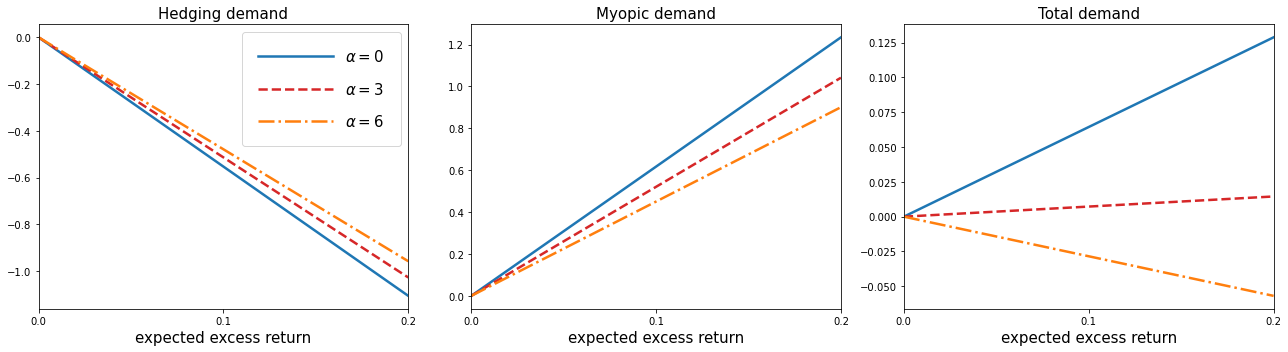

In [218]:
γ = 5
T = 100_000
αs = [0,  3 , 6]
# T = 100_000
Σt = simulate_Σ(T, 0.1, args=(Σ0, B_y, γ, αs[0], δ, r))
K2, K1, K0 = simulate_K0(T, 0.1, args=(Σ0, B_y, γ, αs[0], δ, r), limitingTerm=True)
K24, K14, K04 = simulate_K0(T, 0.1, args=(Σ0, B_y, γ, αs[1], δ, r), limitingTerm=True)
K28, K18, K08 = simulate_K0(T, 0.1, args=(Σ0, B_y, γ, αs[2], δ, r), limitingTerm=True)
K2h, K1h, K0h = simulate_K0(T, 0.1, args=(0.25**2, B_y, γ, αs[0], δ, r), limitingTerm=True)
K24h, K14h, K04h = simulate_K0(T, 0.1, args=(0.25**2, B_y, γ, αs[1], δ, r), limitingTerm=True)
K28h, K18h, K08h = simulate_K0(T, 0.1, args=(0.25**2, B_y, γ, αs[2], δ, r), limitingTerm=True)
K2l, K1l, K0l = simulate_K0(T, 0.1, args=(0.05**2, B_y, γ, αs[0], δ, r), limitingTerm=True)
K24l, K14l, K04l = simulate_K0(T, 0.1, args=(0.05**2, B_y, γ, αs[1], δ, r), limitingTerm=True)
K28l, K18l, K08l = simulate_K0(T, 0.1, args=(0.05**2, B_y, γ, αs[2], δ, r), limitingTerm=True)
excess = np.linspace(0, 0.2)
z = excess + r
# k1 = K1[0]
# k2 = K2[0]
# k14 = K14[0]
# k0 = K0[0]
# k18 = K18[0]
# k28 = K28[0]


def myopic(z, args):
    Σ0, B_y, γ, α, δ, r = args
    return (z - r) / (γ * B_y**2 + α * Σ0)

def hegding(z, k1, k2, args):
    Σ0, B_y, γ, α, δ, r = args
    adjust = (γ - 1) * B_y**2 + α * Σ0
    temp = -(k1 + k2*z) * Σ0 / B_y**2 * adjust 
    temp /= γ * B_y**2 + α * Σ0
    return temp

myopic0 = myopic(z, args=(Σt[0], B_y, γ, αs[0], δ, r))
myopic4 = myopic(z, args=(Σt[0], B_y, γ, αs[1], δ, r))
myopic8 = myopic(z, args=(Σt[0], B_y, γ, αs[2], δ, r))

hedging0 = hegding(z, K1[0], K2[0], args=(Σt[0], B_y, γ, αs[0], δ, r))
hedging4 = hegding(z, K14[0], K24[0], args=(Σt[0], B_y, γ, αs[1], δ, r))
hedging8 = hegding(z, K18[0], K28[0], args=(Σt[0], B_y, γ, αs[2], δ, r))

fig,(ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,5))

ax1.plot(excess,  hedging0, label="$\\alpha = 0$")
ax1.plot(excess,  hedging4, label="$\\alpha = 3$", color="C3", linestyle="--")
ax1.plot(excess,  hedging8, label="$\\alpha = 6$", color="C1", linestyle="-.")
ax1.set_title("Hedging demand", fontsize=15)

ax2.plot(excess, myopic0, label="$\\alpha = 0$")
ax2.plot(excess, myopic4, label="$\\alpha = 4$", color="C3", linestyle="--")
ax2.plot(excess, myopic8, label="$\\alpha = 8$", color="C1", linestyle="-.")
ax2.set_title("Myopic demand", fontsize=15)

ax3.plot(excess, myopic0 +  hedging0, label="$\\alpha = 0$")
ax3.plot(excess, myopic4 +  hedging4, label="$\\alpha = 4$", color="C3", linestyle="--")
ax3.plot(excess, myopic8 +  hedging8, label="$\\alpha = 8$", color="C1", linestyle="-.")
ax3.set_title("Total demand", fontsize=15)

for ax in [ax1, ax2, ax3]:
    ax.set_xticks([0.0, 0.1, 0.2])
    ax.set_xlim(0.0, 0.2)
    ax.set_xlabel("expected excess return", fontsize=15)
ax1.legend(fontsize=15, framealpha=0.8,  handlelength=5, borderpad=1.1, labelspacing=1.1)
    
    
plt.tight_layout()
# plt.savefig("Figure1new.pdf")

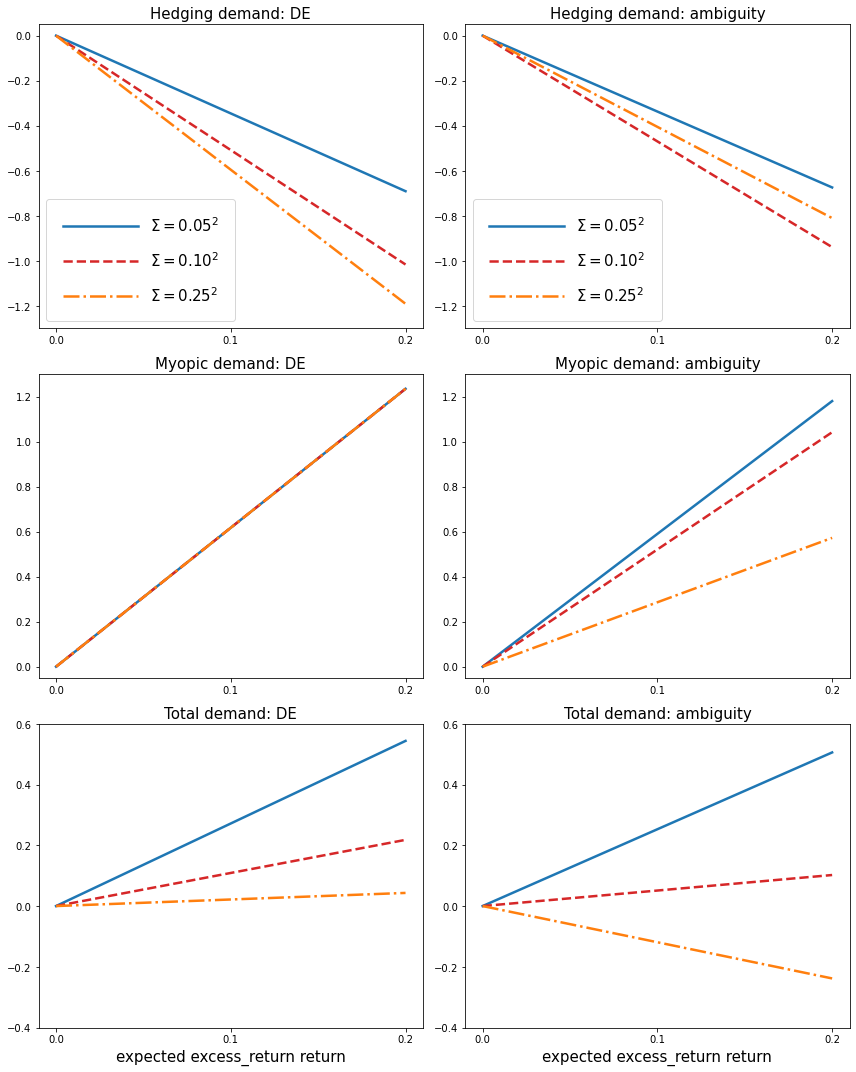

In [46]:
fig, axes = plt.subplots(3,2, figsize=(12, 15))

# γ = 5
# DE
## hedging
α = αs[0]
axes[0,0].plot(excess_return, hegding(excess_return, K2l[0], args=(0.05**2, B_y, γ, α, δ, r)), color="C0")
axes[0,0].plot(excess_return, hegding(excess_return, K2[0], args=(Σt[0], B_y, γ, α, δ, r)), color="C3", linestyle="--")
axes[0,0].plot(excess_return, hegding(excess_return, K2h[0], args=(0.25**2, B_y, γ, α, δ, r)), color="C1", linestyle="-.")
axes[0,0].set_title("Hedging demand: DE", fontsize=15)
## myopic
axes[1,0].plot(excess_return, myopic(excess_return, args=(0.05**2, B_y, γ, α, δ, r)))
axes[1,0].plot(excess_return, myopic(excess_return, args=(Σt[0], B_y, γ, α, δ, r)), color="C3", linestyle="--")
axes[1,0].plot(excess_return, myopic(excess_return, args=(0.25**2, B_y, γ, α, δ, r)), color="C1", linestyle="-.")
axes[1,0].set_title("Myopic demand: DE", fontsize=15)
## total
axes[2,0].plot(excess_return, myopic(excess_return, args=(0.05**2, B_y, γ, α, δ, r)) 
               + hegding(excess_return, K2l[0], args=(0.05**2, B_y, γ, α, δ, r)))
axes[2,0].plot(excess_return, myopic(excess_return, args=(Σt[0], B_y, γ, α, δ, r)) 
               + hegding(excess_return, K2[0], args=(Σt[0], B_y, γ, α, δ, r)), color="C3", linestyle="--")
axes[2,0].plot(excess_return, myopic(excess_return, args=(0.25**2, B_y, γ, α, δ, r)) 
               + hegding(excess_return, K2h[0], args=(0.25**2, B_y, γ, α, δ, r)), color="C1", linestyle="-.")
axes[2,0].set_title("Total demand: DE", fontsize=15)

# ambiguity
α = αs[1]
## hedging
axes[0,1].plot(excess_return, hegding(excess_return, K24l[0], args=(0.05**2, B_y, γ, α, δ, r)))
axes[0,1].plot(excess_return, hegding(excess_return, K24[0], args=(Σt[0], B_y, γ, α, δ, r)), color="C3", linestyle="--")
axes[0,1].plot(excess_return, hegding(excess_return, K24h[0], args=(0.25**2, B_y, γ, α, δ, r)), color="C1", linestyle="-.")
axes[0,1].set_title("Hedging demand: ambiguity", fontsize=15)
## myopic
axes[1,1].plot(excess_return, myopic(excess_return, args=(0.05**2, B_y, γ, α, δ, r)))
axes[1,1].plot(excess_return, myopic(excess_return, args=(Σt[0], B_y, γ, α, δ, r)), color="C3", linestyle="--")
axes[1,1].plot(excess_return, myopic(excess_return, args=(0.25**2, B_y, γ, α, δ, r)), color="C1", linestyle="-.")
axes[1,1].set_title("Myopic demand: ambiguity", fontsize=15)
## total
axes[2,1].plot(excess_return, myopic(excess_return, args=(0.05**2, B_y, γ, α, δ, r)) 
               + hegding(excess_return, K24l[0], args=(0.05**2, B_y, γ, α, δ, r)))
axes[2,1].plot(excess_return, myopic(excess_return, args=(Σt[0], B_y, γ, α, δ, r)) 
               + hegding(excess_return, K24[0], args=(Σt[0], B_y, γ, α, δ, r)), color="C3", linestyle="--")
axes[2,1].plot(excess_return, myopic(excess_return, args=(0.25**2, B_y, γ, α, δ, r)) 
               + hegding(excess_return, K24h[0], args=(0.25**2, B_y, γ, α, δ, r)), color="C1", linestyle="-.")
axes[2,1].set_title("Total demand: ambiguity", fontsize=15)


for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        axes[i,j].set_xticks([0,0.1,0.2])
axes[0,0].legend(["$\\Sigma=0.05^2$", "$\\Sigma=0.10^2$","$\\Sigma=0.25^2$",], fontsize=15, framealpha=0.8,  handlelength=5, borderpad=1.1, labelspacing=1.1)
axes[0,1].legend(["$\\Sigma=0.05^2$", "$\\Sigma=0.10^2$","$\\Sigma=0.25^2$",], fontsize=15, framealpha=0.8,  handlelength=5, borderpad=1.1, labelspacing=1.1)
axes[2,0].set_xlabel("expected excess_return return", fontsize=15)
axes[2,1].set_xlabel("expected excess_return return", fontsize=15)

axes[0,0].set_ylim(-1.3, 0.05)
axes[0,1].set_ylim(-1.3, 0.05)

axes[1,0].set_ylim(-0.05, 1.3)
axes[1,1].set_ylim(-0.05, 1.3)

axes[2,0].set_ylim(-0.4, 0.6)
axes[2,1].set_ylim(-0.4, 0.6)
plt.tight_layout()

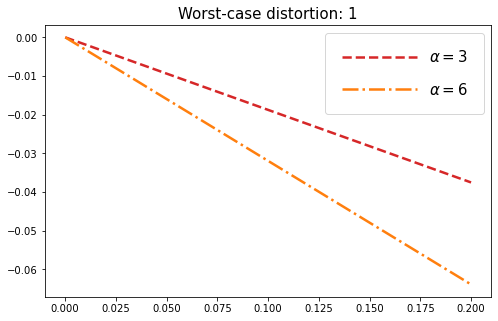

In [219]:
ambiguity4 = Ambiguity(excess, myopic4, hedging4, K24[0], args = (Σ0, B_y, γ, αs[1], δ, r))
ambiguity8 = Ambiguity(excess, myopic8, hedging8, K28[0], args = (Σ0, B_y, γ, αs[2], δ, r))

plt.figure(figsize=(8, 5))
# ax3.plot(excess, myopic0 +  hedging0, label="$\\alpha = 0$")
plt.plot(excess, ambiguity4, label="$\\alpha = 3$", color="C3", linestyle="--")
plt.plot(excess, ambiguity8, label="$\\alpha = 6$", color="C1", linestyle="-.")
plt.title("Worst-case distortion: 1", fontsize=15)
plt.legend(fontsize=15, framealpha=0.8,  handlelength=5, borderpad=1.1, labelspacing=1.1)


In [221]:
ambiguity4[-1] /0.2, ambiguity8[-1] / 0.2

(-0.18752830915266241, -0.31937082206995104)

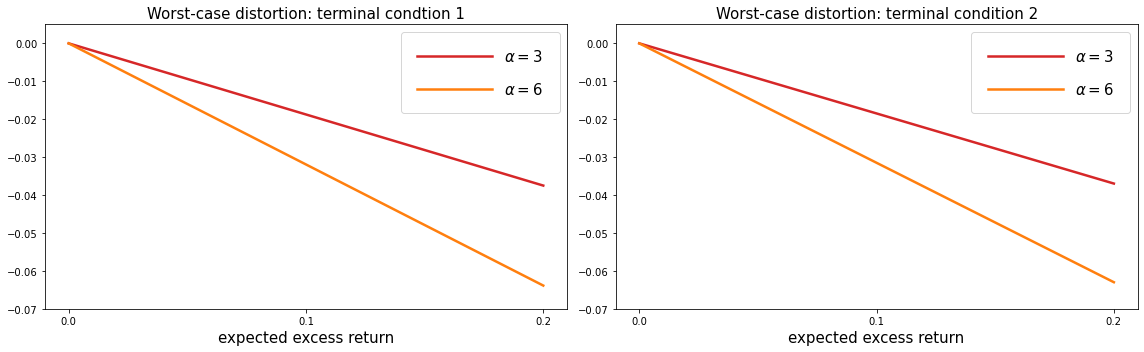

In [210]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
# terminal 1
γ = 5
T = 100_000
αs = [0,  3 , 6]
# T = 100_000
Σt = simulate_Σ(T, 0.1, args=(Σ0, B_y, γ, αs[0], δ, r))
K2, K1, K0 = simulate_K0(T, 0.1, args=(Σ0, B_y, γ, αs[0], δ, r), limitingTerm=True)
K24, K14, K04 = simulate_K0(T, 0.1, args=(Σ0, B_y, γ, αs[1], δ, r), limitingTerm=True)
K28, K18, K08 = simulate_K0(T, 0.1, args=(Σ0, B_y, γ, αs[2], δ, r), limitingTerm=True)
K2h, K1h, K0h = simulate_K0(T, 0.1, args=(0.25**2, B_y, γ, αs[0], δ, r), limitingTerm=True)
K24h, K14h, K04h = simulate_K0(T, 0.1, args=(0.25**2, B_y, γ, αs[1], δ, r), limitingTerm=True)
K28h, K18h, K08h = simulate_K0(T, 0.1, args=(0.25**2, B_y, γ, αs[2], δ, r), limitingTerm=True)
K2l, K1l, K0l = simulate_K0(T, 0.1, args=(0.05**2, B_y, γ, αs[0], δ, r), limitingTerm=True)
K24l, K14l, K04l = simulate_K0(T, 0.1, args=(0.05**2, B_y, γ, αs[1], δ, r), limitingTerm=True)
K28l, K18l, K08l = simulate_K0(T, 0.1, args=(0.05**2, B_y, γ, αs[2], δ, r), limitingTerm=True)

myopic0 = myopic(z, args=(Σt[0], B_y, γ, αs[0], δ, r))
myopic4 = myopic(z, args=(Σt[0], B_y, γ, αs[1], δ, r))
myopic8 = myopic(z, args=(Σt[0], B_y, γ, αs[2], δ, r))

hedging0 = hegding(z, K1[0], K2[0], args=(Σt[0], B_y, γ, αs[0], δ, r))
hedging4 = hegding(z, K14[0], K24[0], args=(Σt[0], B_y, γ, αs[1], δ, r))
hedging8 = hegding(z, K18[0], K28[0], args=(Σt[0], B_y, γ, αs[2], δ, r))

ambiguity4 = Ambiguity(excess, myopic4, hedging4, K24[0], args = (Σ0, B_y, γ, αs[1], δ, r))
ambiguity8 = Ambiguity(excess, myopic8, hedging8, K28[0], args = (Σ0, B_y, γ, αs[2], δ, r))
# print(ambiguity4, ambiguity8)

# ax3.plot(excess, myopic0 +  hedging0, label="$\\alpha = 0$")
ax1.plot(excess, ambiguity4, label="$\\alpha = 3$", color="C3", )
ax1.plot(excess, ambiguity8, label="$\\alpha = 6$", color="C1",  )
ax1.set_title("Worst-case distortion: terminal condtion 1", fontsize=15)
ax1.legend(fontsize=15, framealpha=0.8,  handlelength=5, borderpad=1.1, labelspacing=1.1)
ax1.set_ylim(-0.07, 0.005)
# terminal 2
γ = 5
T = 25
αs = [0,  3 , 6]
# T = 100_000
Σt = simulate_Σ(T, 0.1, args=(Σ0, B_y, γ, αs[0], δ, r))
K2, K1, K0 = simulate_K0(T, 0.1, args=(Σ0, B_y, γ, αs[0], δ, r), limitingTerm=False)
K24, K14, K04 = simulate_K0(T, 0.1, args=(Σ0, B_y, γ, αs[1], δ, r), limitingTerm=False)
K28, K18, K08 = simulate_K0(T, 0.1, args=(Σ0, B_y, γ, αs[2], δ, r), limitingTerm=False)
K2h, K1h, K0h = simulate_K0(T, 0.1, args=(0.25**2, B_y, γ, αs[0], δ, r), limitingTerm=False)
K24h, K14h, K04h = simulate_K0(T, 0.1, args=(0.25**2, B_y, γ, αs[1], δ, r), limitingTerm=False)
K28h, K18h, K08h = simulate_K0(T, 0.1, args=(0.25**2, B_y, γ, αs[2], δ, r), limitingTerm=False)
K2l, K1l, K0l = simulate_K0(T, 0.1, args=(0.05**2, B_y, γ, αs[0], δ, r), limitingTerm=False)
K24l, K14l, K04l = simulate_K0(T, 0.1, args=(0.05**2, B_y, γ, αs[1], δ, r), limitingTerm=False)
K28l, K18l, K08l = simulate_K0(T, 0.1, args=(0.05**2, B_y, γ, αs[2], δ, r), limitingTerm=False)

myopic0 = myopic(z, args=(Σt[0], B_y, γ, αs[0], δ, r))
myopic4 = myopic(z, args=(Σt[0], B_y, γ, αs[1], δ, r))
myopic8 = myopic(z, args=(Σt[0], B_y, γ, αs[2], δ, r))

hedging0 = hegding(z, K1[0], K2[0], args=(Σt[0], B_y, γ, αs[0], δ, r))
hedging4 = hegding(z, K14[0], K24[0], args=(Σt[0], B_y, γ, αs[1], δ, r))
hedging8 = hegding(z, K18[0], K28[0], args=(Σt[0], B_y, γ, αs[2], δ, r))

ambiguity4 = Ambiguity(excess, myopic4, hedging4, K24[0], args = (Σ0, B_y, γ, αs[1], δ, r))
ambiguity8 = Ambiguity(excess, myopic8, hedging8, K28[0], args = (Σ0, B_y, γ, αs[2], δ, r))
# print(ambiguity4, ambiguity8)
# ax3.plot(excess, myopic0 +  hedging0, label="$\\alpha = 0$")
ax2.plot(excess, ambiguity4, label="$\\alpha = 3$", color="C3", )
ax2.plot(excess, ambiguity8, label="$\\alpha = 6$", color="C1",)
ax2.set_title("Worst-case distortion: terminal condition 2", fontsize=15)
ax2.legend(fontsize=15, framealpha=0.8,  handlelength=5, borderpad=1.1, labelspacing=1.1)
ax2.set_ylim(-0.07, 0.005)


for ax in [ax1, ax2]:
    ax.set_xticks([0,0.1, 0.2])
    ax.set_xlabel("expected excess return", fontsize=15)
    
plt.tight_layout()
# plt.savefig("Distortion.pdf")

In [201]:
Σ0, dt

(0.010000000000000002, 0.1)

-0.18752830915266241 -0.31937082206995104
-0.18486026534431296 -0.3149646311893664


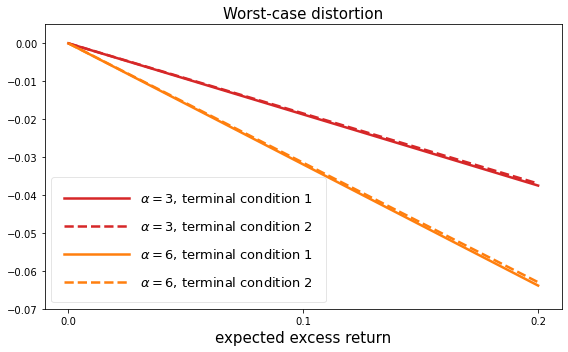

In [213]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))
# terminal 1
γ = 5
T = 100_000
αs = [0,  3 , 6]
# T = 100_000
Σt = simulate_Σ(T, 0.1, args=(Σ0, B_y, γ, αs[0], δ, r))
K2, K1, K0 = simulate_K0(T, 0.1, args=(Σ0, B_y, γ, αs[0], δ, r), limitingTerm=True)
K24, K14, K04 = simulate_K0(T, 0.1, args=(Σ0, B_y, γ, αs[1], δ, r), limitingTerm=True)
K28, K18, K08 = simulate_K0(T, 0.1, args=(Σ0, B_y, γ, αs[2], δ, r), limitingTerm=True)
K2h, K1h, K0h = simulate_K0(T, 0.1, args=(0.25**2, B_y, γ, αs[0], δ, r), limitingTerm=True)
K24h, K14h, K04h = simulate_K0(T, 0.1, args=(0.25**2, B_y, γ, αs[1], δ, r), limitingTerm=True)
K28h, K18h, K08h = simulate_K0(T, 0.1, args=(0.25**2, B_y, γ, αs[2], δ, r), limitingTerm=True)
K2l, K1l, K0l = simulate_K0(T, 0.1, args=(0.05**2, B_y, γ, αs[0], δ, r), limitingTerm=True)
K24l, K14l, K04l = simulate_K0(T, 0.1, args=(0.05**2, B_y, γ, αs[1], δ, r), limitingTerm=True)
K28l, K18l, K08l = simulate_K0(T, 0.1, args=(0.05**2, B_y, γ, αs[2], δ, r), limitingTerm=True)

myopic0 = myopic(z, args=(Σt[0], B_y, γ, αs[0], δ, r))
myopic4 = myopic(z, args=(Σt[0], B_y, γ, αs[1], δ, r))
myopic8 = myopic(z, args=(Σt[0], B_y, γ, αs[2], δ, r))

hedging0 = hegding(z, K1[0], K2[0], args=(Σt[0], B_y, γ, αs[0], δ, r))
hedging4 = hegding(z, K14[0], K24[0], args=(Σt[0], B_y, γ, αs[1], δ, r))
hedging8 = hegding(z, K18[0], K28[0], args=(Σt[0], B_y, γ, αs[2], δ, r))

ambiguity4 = Ambiguity(excess, myopic4, hedging4, K24[0], args = (Σ0, B_y, γ, αs[1], δ, r))
ambiguity8 = Ambiguity(excess, myopic8, hedging8, K28[0], args = (Σ0, B_y, γ, αs[2], δ, r))
print(ambiguity4[-1] / 0.2, ambiguity8[-1] / 0.2)

# ax3.plot(excess, myopic0 +  hedging0, label="$\\alpha = 0$")
ax1.plot(excess, ambiguity4, label="$\\alpha = 3$, terminal condition 1", color="C3", )
ax1.plot(excess, ambiguity8, label="$\\alpha = 6$, terminal condition 1", color="C1",)
ax1.set_title("Worst-case distortion", fontsize=15)
# ax1.legend(fontsize=15, framealpha=0.8,  handlelength=5, borderpad=1.1, labelspacing=1.1)
ax1.set_ylim(-0.07, 0.005)
# terminal 2
γ = 5
T = 25
αs = [0,  3 , 6]
# T = 100_000
Σt = simulate_Σ(T, 0.1, args=(Σ0, B_y, γ, αs[0], δ, r))
K2, K1, K0 = simulate_K0(T, 0.1, args=(Σ0, B_y, γ, αs[0], δ, r), limitingTerm=False)
K24, K14, K04 = simulate_K0(T, 0.1, args=(Σ0, B_y, γ, αs[1], δ, r), limitingTerm=False)
K28, K18, K08 = simulate_K0(T, 0.1, args=(Σ0, B_y, γ, αs[2], δ, r), limitingTerm=False)
K2h, K1h, K0h = simulate_K0(T, 0.1, args=(0.25**2, B_y, γ, αs[0], δ, r), limitingTerm=False)
K24h, K14h, K04h = simulate_K0(T, 0.1, args=(0.25**2, B_y, γ, αs[1], δ, r), limitingTerm=False)
K28h, K18h, K08h = simulate_K0(T, 0.1, args=(0.25**2, B_y, γ, αs[2], δ, r), limitingTerm=False)
K2l, K1l, K0l = simulate_K0(T, 0.1, args=(0.05**2, B_y, γ, αs[0], δ, r), limitingTerm=False)
K24l, K14l, K04l = simulate_K0(T, 0.1, args=(0.05**2, B_y, γ, αs[1], δ, r), limitingTerm=False)
K28l, K18l, K08l = simulate_K0(T, 0.1, args=(0.05**2, B_y, γ, αs[2], δ, r), limitingTerm=False)

myopic0 = myopic(z, args=(Σt[0], B_y, γ, αs[0], δ, r))
myopic4 = myopic(z, args=(Σt[0], B_y, γ, αs[1], δ, r))
myopic8 = myopic(z, args=(Σt[0], B_y, γ, αs[2], δ, r))

hedging0 = hegding(z, K1[0], K2[0], args=(Σt[0], B_y, γ, αs[0], δ, r))
hedging4 = hegding(z, K14[0], K24[0], args=(Σt[0], B_y, γ, αs[1], δ, r))
hedging8 = hegding(z, K18[0], K28[0], args=(Σt[0], B_y, γ, αs[2], δ, r))

ambiguity4 = Ambiguity(excess, myopic4, hedging4, K24[0], args = (Σ0, B_y, γ, αs[1], δ, r))
ambiguity8 = Ambiguity(excess, myopic8, hedging8, K28[0], args = (Σ0, B_y, γ, αs[2], δ, r))
print(ambiguity4[-1]/0.2, ambiguity8[-1]/0.2)
# ax3.plot(excess, myopic0 +  hedging0, label="$\\alpha = 0$")
ax1.plot(excess, ambiguity4, label="$\\alpha = 3$, terminal condition 2", color="C3", linestyle="--")
ax1.plot(excess, ambiguity8, label="$\\alpha = 6$, terminal condition 2", color="C1", linestyle="--")
ax1.set_title("Worst-case distortion", fontsize=15)
# ax1.legend(fontsize=15, framealpha=0.8,  handlelength=5, borderpad=1.1, labelspacing=1.1)
ax1.set_ylim(-0.07, 0.005)


for ax in [ax1]:
    ax.set_xticks([0,0.1, 0.2])
    ax.set_xlabel("expected excess return", fontsize=15)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
           fontsize=13, framealpha=0.5,  handlelength=5, borderpad=1, labelspacing=1)    

plt.tight_layout()

# plt.savefig("Distortion_oneplot.pdf")

In [139]:
Slopes = []
Alphas = [0, 4, 8]
Ktwos = [kk2[0], kk24[0], kk28[0]]
Coeffs = [COEFF0, COEFF4, COEFF8]
for alpha, k2, coo in zip(Alphas, Ktwos, Coeffs):
    temp = {
        "Hedging demand": - k2 * coo,
        "Myopic demand": 1 / (γ * B_y**2 + alpha * Σ0),
        "Total demand": 1 / (γ * B_y**2 + alpha * Σ0) - k2 * coo
    }
    Slopes.append(temp)

In [143]:
Slopesl = []
Alphas = [0, 4, 8]
Ktwosl = [kk2l[0], kk24l[0], kk28l[0]]
Coeffsl = [COEFF0l, COEFF4l, COEFF8l]
for alpha, k2, coo in zip(Alphas, Ktwosl, Coeffsl):
    temp = {
        "Hedging demand": - k2 * coo,
        "Myopic demand": 1 / (γ * B_y**2 + alpha * 0.05**2),
        "Total demand": 1 / (γ * B_y**2 + alpha * 0.05**2) - k2 * coo
    }
    Slopesl.append(temp)

In [144]:
Slopesh = []
Alphas = [0, 4, 8]
Ktwosh = [kk2h[0], kk24h[0], kk28h[0]]
Coeffsh = [COEFF0h, COEFF4h, COEFF8h]
for alpha, k2, coo in zip(Alphas, Ktwosh, Coeffsh):
    temp = {
        "Hedging demand": - k2 * coo,
        "Myopic demand": 1 / (γ * B_y**2 + alpha * 0.25**2),
        "Total demand": 1 / (γ * B_y**2 + alpha * 0.25**2) - k2 * coo
    }
    Slopesh.append(temp)

In [121]:
Slopes

[{'Hedging demand': -5.066052520208689,
  'Myopic demand': 6.17283950617284,
  'Total demand': 1.1067869859641517},
 {'Hedging demand': -4.562552684513753,
  'Myopic demand': 4.9504950495049505,
  'Total demand': 0.38794236499119705},
 {'Hedging demand': -4.142052014563779,
  'Myopic demand': 4.132231404958678,
  'Total demand': -0.009820609605101005}]

In [145]:
import pandas as pd
Slopes = pd.DataFrame(Slopes, index=["α = 0","α = 4","α = 8"])
Slopesl = pd.DataFrame(Slopesl, index=["α = 0","α = 4","α = 8"])
Slopesh = pd.DataFrame(Slopesh, index=["α = 0","α = 4","α = 8"])

In [146]:
Slopesl

,Hedging demand,Myopic demand,Total demand
α = 0,-4.585297,6.172840,1.587543
α = 4,-4.460567,5.813953,1.353386
α = 8,-4.340966,5.494505,1.153540


In [147]:
Slopes

,Hedging demand,Myopic demand,Total demand
α = 0,-5.529050,6.172840,0.643790
α = 4,-5.015042,4.950495,-0.064547
α = 8,-4.581866,4.132231,-0.449635


In [148]:
Slopesh

,Hedging demand,Myopic demand,Total demand
α = 0,-6.027631,6.172840,0.145209
α = 4,-3.734209,2.427184,-1.307025
α = 8,-2.756777,1.510574,-1.246203
